In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import random
import time
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1234)
X, Y = make_moons(200, noise = 0.1)

# Split into test and training data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=73)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

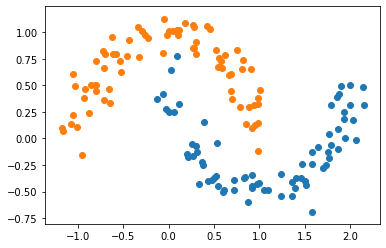

In [3]:
import matplotlib.pyplot as plt
plt.scatter(*x_train[y_train.flatten() == 1, :].T)
plt.scatter(*x_train[y_train.flatten() == 0, :].T)
plt.show()

In [4]:
type(x_train), np.shape(y_train)

(numpy.ndarray, (150, 1))

In [5]:
# Standard BP
model_bp = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(100, activation = "sigmoid"),
        #layers.Dense(50, activation = "sigmoid"),
        layers.Dense(1, activation = "sigmoid")
    ]
)
model_bp.summary()
#model_bp.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [6]:
import time
batch_size = 32
epochs = 1000
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

st = time.time()
model_bp.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model_bp.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
print(time.time() - st)

Epoch 1/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.3867
Epoch 2/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5267
Epoch 3/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.6759 - accuracy: 0.6133
Epoch 4/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6733
Epoch 5/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.4600
Epoch 6/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.6429 - accuracy: 0.7533
Epoch 7/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.8333
Epoch 8/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.6145 - accuracy: 0.8867
Epoch 9/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.6095 - accuracy: 0.7733
Epoch 10/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.6007 - accuracy: 0.7733
Epoch 11/1000
5/5 [

5/5 [==============================] - 0s 2ms/step - loss: 0.3039 - accuracy: 0.8667
Epoch 84/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3014 - accuracy: 0.8600
Epoch 85/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.3029 - accuracy: 0.8733
Epoch 86/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3051 - accuracy: 0.8733
Epoch 87/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3014 - accuracy: 0.8667
Epoch 88/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3019 - accuracy: 0.8600
Epoch 89/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2981 - accuracy: 0.8667
Epoch 90/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.3008 - accuracy: 0.8600
Epoch 91/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.2991 - accuracy: 0.8667
Epoch 92/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.8667
Epoch 93/1000
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.2678 - accuracy: 0.8800
Epoch 166/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy: 0.8733
Epoch 167/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2708 - accuracy: 0.8667
Epoch 168/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2656 - accuracy: 0.8800
Epoch 169/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2667 - accuracy: 0.8733
Epoch 170/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2666 - accuracy: 0.8800
Epoch 171/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2665 - accuracy: 0.8800
Epoch 172/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2659 - accuracy: 0.8800
Epoch 173/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2660 - accuracy: 0.8800
Epoch 174/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2677 - accuracy: 0.8800
Epoch 175/1000


5/5 [==============================] - 0s 1ms/step - loss: 0.2604 - accuracy: 0.8867
Epoch 248/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2592 - accuracy: 0.8800
Epoch 249/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2623 - accuracy: 0.8867
Epoch 250/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2615 - accuracy: 0.8933
Epoch 251/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2587 - accuracy: 0.8800
Epoch 252/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2618 - accuracy: 0.8867
Epoch 253/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.8933
Epoch 254/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2595 - accuracy: 0.8867
Epoch 255/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.8867
Epoch 256/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2584 - accuracy: 0.8867
Epoch 257/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.8933
Epoch 329/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.8867
Epoch 330/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2595 - accuracy: 0.8800
Epoch 331/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2595 - accuracy: 0.8867
Epoch 332/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2590 - accuracy: 0.8867
Epoch 333/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2592 - accuracy: 0.8800
Epoch 334/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.8933
Epoch 335/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2608 - accuracy: 0.8800
Epoch 336/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2583 - accuracy: 0.8867
Epoch 337/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2607 - accuracy: 0.8733
Epoch 338/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2592 - accuracy: 0.9067
Epoch 411/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2570 - accuracy: 0.8800
Epoch 412/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2579 - accuracy: 0.8933
Epoch 413/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2570 - accuracy: 0.8867
Epoch 414/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2565 - accuracy: 0.8867
Epoch 415/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2574 - accuracy: 0.8867
Epoch 416/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2589 - accuracy: 0.8800
Epoch 417/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2559 - accuracy: 0.8800
Epoch 418/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2584 - accuracy: 0.8800
Epoch 419/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2576 - accuracy: 0.8933
Epoch 420/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2567 - accuracy: 0.8867
Epoch 493/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2568 - accuracy: 0.8800
Epoch 494/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2573 - accuracy: 0.8867
Epoch 495/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2560 - accuracy: 0.8867
Epoch 496/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2565 - accuracy: 0.8733
Epoch 497/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2577 - accuracy: 0.8933
Epoch 498/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2570 - accuracy: 0.8733
Epoch 499/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.8867
Epoch 500/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2577 - accuracy: 0.8800
Epoch 501/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.8867
Epoch 502/1000


5/5 [==============================] - 0s 3ms/step - loss: 0.2584 - accuracy: 0.8733
Epoch 575/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2639 - accuracy: 0.8800
Epoch 576/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.9000
Epoch 577/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2579 - accuracy: 0.8933
Epoch 578/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2572 - accuracy: 0.8733
Epoch 579/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2584 - accuracy: 0.8800
Epoch 580/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2582 - accuracy: 0.8867
Epoch 581/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.8933
Epoch 582/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.8733
Epoch 583/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2561 - accuracy: 0.8800
Epoch 584/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2562 - accuracy: 0.8867
Epoch 657/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2567 - accuracy: 0.8867
Epoch 658/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2600 - accuracy: 0.8800
Epoch 659/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.8933
Epoch 660/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2679 - accuracy: 0.8867
Epoch 661/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2565 - accuracy: 0.8800
Epoch 662/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2573 - accuracy: 0.8867
Epoch 663/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.8867
Epoch 664/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2575 - accuracy: 0.8867
Epoch 665/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2573 - accuracy: 0.8867
Epoch 666/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2648 - accuracy: 0.8800
Epoch 739/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2598 - accuracy: 0.8800
Epoch 740/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8867
Epoch 741/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2590 - accuracy: 0.8733
Epoch 742/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2624 - accuracy: 0.8867
Epoch 743/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2650 - accuracy: 0.8733
Epoch 744/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.9000
Epoch 745/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.8867
Epoch 746/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2578 - accuracy: 0.8867
Epoch 747/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2565 - accuracy: 0.8867
Epoch 748/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2570 - accuracy: 0.8867
Epoch 821/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2613 - accuracy: 0.8800
Epoch 822/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2581 - accuracy: 0.8933
Epoch 823/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2568 - accuracy: 0.8867
Epoch 824/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.8733
Epoch 825/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2560 - accuracy: 0.8933
Epoch 826/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.8867
Epoch 827/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2567 - accuracy: 0.8733
Epoch 828/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2565 - accuracy: 0.8867
Epoch 829/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2634 - accuracy: 0.8733
Epoch 830/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2593 - accuracy: 0.8867
Epoch 903/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2576 - accuracy: 0.8933
Epoch 904/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2563 - accuracy: 0.8867
Epoch 905/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2560 - accuracy: 0.8800
Epoch 906/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8933
Epoch 907/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2600 - accuracy: 0.8867
Epoch 908/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2573 - accuracy: 0.8933
Epoch 909/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2579 - accuracy: 0.8933
Epoch 910/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.8867
Epoch 911/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2583 - accuracy: 0.8800
Epoch 912/1000


5/5 [==============================] - 0s 2ms/step - loss: 0.2588 - accuracy: 0.8933
Epoch 985/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2589 - accuracy: 0.8800
Epoch 986/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2562 - accuracy: 0.8867
Epoch 987/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.8800
Epoch 988/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2604 - accuracy: 0.8933
Epoch 989/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.2592 - accuracy: 0.8733
Epoch 990/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2609 - accuracy: 0.8867
Epoch 991/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2576 - accuracy: 0.8867
Epoch 992/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.8867
Epoch 993/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2574 - accuracy: 0.8800
Epoch 994/1000


In [7]:
def convert2_zero_one(x):
    
    t = [tm.sigmoid(i) for i in x]
    
    return t

In [8]:
def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tm.greater(tm.abs(x), r), tf.float32)
    sign = tm.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [9]:
def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)


In [10]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
    
    def call(self, x):
        
        #x = Flatten()(x)
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
        
        new_step_size = samples[2].new_step_size.numpy()
        ker_new = self.generate_hmc_kernel(x, y, new_step_size)
        
        #h_state = rerange(samples[0][0])
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1)   

        return(h_new, ker_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return labels

In [11]:
model = StochasticMLP(hidden_layer_sizes = [100], n_outputs=1)

In [12]:
network = [model.call(x) for x, y in train_ds]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [13]:
kernels = [model.generate_hmc_kernel(x, y) for x, y in train_ds]

In [14]:
%%time

burnin = 500
for i in range(burnin):
    
    if(i % 100 == 0): print("Step %d" % i)
        
    network_new = []
    kernels_new = []
    
    res = [model.propose_new_state_hamiltonian(x, net, y, ker) 
               for (x, y), net, ker in zip(train_ds, network, kernels)]
    
    network_new, kernels_new = zip(*res)
         
    network = network_new
    kernels = kernels_new

Step 0
Step 100
Step 200
Step 300
Step 400
CPU times: user 1min 5s, sys: 328 ms, total: 1min 6s
Wall time: 1min 5s


In [15]:
print(network[0])

[<tf.Tensor: shape=(32, 100), dtype=float32, numpy=
array([[ 349.65747  , -244.25192  ,  313.2475   , ...,  116.688194 ,
          53.1697   ,  772.38574  ],
       [ -31.028887 , -254.65196  ,  -85.08907  , ...,  422.48212  ,
        -294.3125   ,   74.16836  ],
       [ 161.50674  , -302.30267  ,   94.96066  , ...,  550.3931   ,
          88.87521  , -229.80414  ],
       ...,
       [-384.75098  , -645.2053   ,    2.5158153, ...,   -6.345684 ,
          31.281593 ,   -1.8017426],
       [ 216.5517   ,  -98.67944  ,   -9.729687 , ...,  314.69812  ,
        -450.967    , -212.38213  ],
       [ 152.50455  ,  -74.160995 ,  185.55643  , ..., -111.32503  ,
         165.66296  ,  183.36806  ]], dtype=float32)>]


In [16]:
epochs = 1000

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (x, y) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(x, network[bs], y, 0.1)
        
        network_new = []

        for net, hmc_kernel in zip(network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = tf.concat(net_current, axis = 1)
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [100], axis = 1)   
            network_new.append(net_new)
   
        network = network_new
        
        loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y))
    
    preds = [model.get_predictions(images) for images, labels in train_ds]
    train_acc = accuracy_score(np.concatenate(preds), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

Epoch 1/1000: - 0.8241s/step - loss: 692.9984 - accuracy: 0.4867
Epoch 2/1000: - 0.7756s/step - loss: 691.4595 - accuracy: 0.7733
Epoch 3/1000: - 0.7569s/step - loss: 690.2958 - accuracy: 0.7667
Epoch 4/1000: - 0.7482s/step - loss: 689.4965 - accuracy: 0.7800
Epoch 5/1000: - 0.7426s/step - loss: 688.2783 - accuracy: 0.7933
Epoch 6/1000: - 0.7528s/step - loss: 687.9914 - accuracy: 0.7933
Epoch 7/1000: - 0.7497s/step - loss: 687.2189 - accuracy: 0.7933
Epoch 8/1000: - 0.7474s/step - loss: 686.3066 - accuracy: 0.8267
Epoch 9/1000: - 0.7537s/step - loss: 685.8120 - accuracy: 0.8267
Epoch 10/1000: - 0.7508s/step - loss: 685.3871 - accuracy: 0.8533
Epoch 11/1000: - 0.7538s/step - loss: 684.4713 - accuracy: 0.8467
Epoch 12/1000: - 0.7555s/step - loss: 683.9108 - accuracy: 0.8533
Epoch 13/1000: - 0.7531s/step - loss: 683.3729 - accuracy: 0.8533
Epoch 14/1000: - 0.7505s/step - loss: 683.0090 - accuracy: 0.8533
Epoch 15/1000: - 0.7542s/step - loss: 682.9729 - accuracy: 0.8667
Epoch 16/1000: - 0.

Epoch 125/1000: - 0.7503s/step - loss: 675.7782 - accuracy: 0.8733
Epoch 126/1000: - 0.7501s/step - loss: 675.8459 - accuracy: 0.8733
Epoch 127/1000: - 0.7498s/step - loss: 675.8444 - accuracy: 0.8800
Epoch 128/1000: - 0.7497s/step - loss: 675.9110 - accuracy: 0.8800
Epoch 129/1000: - 0.7494s/step - loss: 675.9258 - accuracy: 0.8800
Epoch 130/1000: - 0.7491s/step - loss: 675.8490 - accuracy: 0.8800
Epoch 131/1000: - 0.7489s/step - loss: 675.9271 - accuracy: 0.8800
Epoch 132/1000: - 0.7486s/step - loss: 675.7877 - accuracy: 0.8800
Epoch 133/1000: - 0.7483s/step - loss: 675.7360 - accuracy: 0.8800
Epoch 134/1000: - 0.7481s/step - loss: 675.5779 - accuracy: 0.8800
Epoch 135/1000: - 0.7480s/step - loss: 675.5488 - accuracy: 0.8800
Epoch 136/1000: - 0.7479s/step - loss: 675.5266 - accuracy: 0.8800
Epoch 137/1000: - 0.7482s/step - loss: 675.5029 - accuracy: 0.8800
Epoch 138/1000: - 0.7480s/step - loss: 675.5604 - accuracy: 0.8800
Epoch 139/1000: - 0.7478s/step - loss: 675.4565 - accuracy: 0.

Epoch 248/1000: - 0.7391s/step - loss: 673.5120 - accuracy: 0.8867
Epoch 249/1000: - 0.7390s/step - loss: 673.4927 - accuracy: 0.8867
Epoch 250/1000: - 0.7389s/step - loss: 673.4807 - accuracy: 0.8800
Epoch 251/1000: - 0.7389s/step - loss: 673.4955 - accuracy: 0.8800
Epoch 252/1000: - 0.7389s/step - loss: 673.4774 - accuracy: 0.8800
Epoch 253/1000: - 0.7395s/step - loss: 673.4642 - accuracy: 0.8800
Epoch 254/1000: - 0.7401s/step - loss: 673.3855 - accuracy: 0.8800
Epoch 255/1000: - 0.7403s/step - loss: 673.3732 - accuracy: 0.8800
Epoch 256/1000: - 0.7403s/step - loss: 673.3633 - accuracy: 0.8800
Epoch 257/1000: - 0.7404s/step - loss: 673.3551 - accuracy: 0.8800
Epoch 258/1000: - 0.7404s/step - loss: 673.4604 - accuracy: 0.8867
Epoch 259/1000: - 0.7404s/step - loss: 673.4998 - accuracy: 0.8800
Epoch 260/1000: - 0.7404s/step - loss: 673.4888 - accuracy: 0.8800
Epoch 261/1000: - 0.7403s/step - loss: 673.5018 - accuracy: 0.8800
Epoch 262/1000: - 0.7402s/step - loss: 673.4889 - accuracy: 0.

Epoch 371/1000: - 0.7391s/step - loss: 672.8388 - accuracy: 0.8800
Epoch 372/1000: - 0.7393s/step - loss: 672.9230 - accuracy: 0.8800
Epoch 373/1000: - 0.7392s/step - loss: 673.1946 - accuracy: 0.8800
Epoch 374/1000: - 0.7395s/step - loss: 673.1673 - accuracy: 0.8800
Epoch 375/1000: - 0.7395s/step - loss: 672.9498 - accuracy: 0.8800
Epoch 376/1000: - 0.7397s/step - loss: 672.9272 - accuracy: 0.8800
Epoch 377/1000: - 0.7397s/step - loss: 672.9176 - accuracy: 0.8800
Epoch 378/1000: - 0.7396s/step - loss: 672.8978 - accuracy: 0.8800
Epoch 379/1000: - 0.7396s/step - loss: 672.9385 - accuracy: 0.8800
Epoch 380/1000: - 0.7400s/step - loss: 672.9171 - accuracy: 0.8800
Epoch 381/1000: - 0.7403s/step - loss: 672.9026 - accuracy: 0.8800
Epoch 382/1000: - 0.7404s/step - loss: 672.8922 - accuracy: 0.8800
Epoch 383/1000: - 0.7404s/step - loss: 672.8842 - accuracy: 0.8800
Epoch 384/1000: - 0.7405s/step - loss: 672.8322 - accuracy: 0.8800
Epoch 385/1000: - 0.7405s/step - loss: 672.6902 - accuracy: 0.

Epoch 494/1000: - 0.7636s/step - loss: 672.1079 - accuracy: 0.9067
Epoch 495/1000: - 0.7639s/step - loss: 672.0930 - accuracy: 0.9067
Epoch 496/1000: - 0.7642s/step - loss: 672.0514 - accuracy: 0.9067
Epoch 497/1000: - 0.7644s/step - loss: 672.0991 - accuracy: 0.9067
Epoch 498/1000: - 0.7646s/step - loss: 672.0842 - accuracy: 0.9067
Epoch 499/1000: - 0.7648s/step - loss: 672.0846 - accuracy: 0.9067
Epoch 500/1000: - 0.7649s/step - loss: 672.1318 - accuracy: 0.9067
Epoch 501/1000: - 0.7649s/step - loss: 672.1114 - accuracy: 0.9067
Epoch 502/1000: - 0.7655s/step - loss: 672.0967 - accuracy: 0.9067
Epoch 503/1000: - 0.7655s/step - loss: 672.1493 - accuracy: 0.9067
Epoch 504/1000: - 0.7655s/step - loss: 672.1357 - accuracy: 0.9067
Epoch 505/1000: - 0.7656s/step - loss: 672.1253 - accuracy: 0.9067
Epoch 506/1000: - 0.7657s/step - loss: 672.0632 - accuracy: 0.9067
Epoch 507/1000: - 0.7658s/step - loss: 672.0320 - accuracy: 0.9067
Epoch 508/1000: - 0.7661s/step - loss: 672.0211 - accuracy: 0.

Epoch 617/1000: - 0.7647s/step - loss: 671.0413 - accuracy: 0.9067
Epoch 618/1000: - 0.7647s/step - loss: 671.0316 - accuracy: 0.9067
Epoch 619/1000: - 0.7646s/step - loss: 671.0289 - accuracy: 0.9067
Epoch 620/1000: - 0.7645s/step - loss: 670.9661 - accuracy: 0.9067
Epoch 621/1000: - 0.7645s/step - loss: 670.9457 - accuracy: 0.9067
Epoch 622/1000: - 0.7644s/step - loss: 671.0109 - accuracy: 0.9067
Epoch 623/1000: - 0.7643s/step - loss: 670.9982 - accuracy: 0.9067
Epoch 624/1000: - 0.7643s/step - loss: 670.9979 - accuracy: 0.9067
Epoch 625/1000: - 0.7643s/step - loss: 671.0412 - accuracy: 0.9067
Epoch 626/1000: - 0.7642s/step - loss: 671.0251 - accuracy: 0.9067
Epoch 627/1000: - 0.7641s/step - loss: 671.0123 - accuracy: 0.9067
Epoch 628/1000: - 0.7640s/step - loss: 671.0018 - accuracy: 0.9067
Epoch 629/1000: - 0.7640s/step - loss: 670.9928 - accuracy: 0.9067
Epoch 630/1000: - 0.7639s/step - loss: 670.9850 - accuracy: 0.9067
Epoch 631/1000: - 0.7638s/step - loss: 670.9781 - accuracy: 0.

Epoch 740/1000: - 0.7633s/step - loss: 670.7485 - accuracy: 0.9067
Epoch 741/1000: - 0.7634s/step - loss: 670.7381 - accuracy: 0.9067
Epoch 742/1000: - 0.7635s/step - loss: 670.7078 - accuracy: 0.9067
Epoch 743/1000: - 0.7636s/step - loss: 670.6810 - accuracy: 0.9067
Epoch 744/1000: - 0.7636s/step - loss: 670.6639 - accuracy: 0.9067
Epoch 745/1000: - 0.7636s/step - loss: 670.6774 - accuracy: 0.9067
Epoch 746/1000: - 0.7636s/step - loss: 670.6650 - accuracy: 0.9067
Epoch 747/1000: - 0.7636s/step - loss: 670.6562 - accuracy: 0.9067
Epoch 748/1000: - 0.7635s/step - loss: 670.6498 - accuracy: 0.9067
Epoch 749/1000: - 0.7639s/step - loss: 670.6447 - accuracy: 0.9067
Epoch 750/1000: - 0.7640s/step - loss: 670.6404 - accuracy: 0.9067
Epoch 751/1000: - 0.7641s/step - loss: 670.6367 - accuracy: 0.9067
Epoch 752/1000: - 0.7641s/step - loss: 670.6542 - accuracy: 0.9067
Epoch 753/1000: - 0.7642s/step - loss: 670.6302 - accuracy: 0.9067
Epoch 754/1000: - 0.7642s/step - loss: 670.6159 - accuracy: 0.

Epoch 863/1000: - 0.7619s/step - loss: 670.1780 - accuracy: 0.9067
Epoch 864/1000: - 0.7619s/step - loss: 670.1741 - accuracy: 0.9067
Epoch 865/1000: - 0.7619s/step - loss: 670.1711 - accuracy: 0.9067
Epoch 866/1000: - 0.7618s/step - loss: 670.2147 - accuracy: 0.9067
Epoch 867/1000: - 0.7618s/step - loss: 670.2275 - accuracy: 0.9067
Epoch 868/1000: - 0.7618s/step - loss: 670.2786 - accuracy: 0.9067
Epoch 869/1000: - 0.7617s/step - loss: 670.2682 - accuracy: 0.9067
Epoch 870/1000: - 0.7617s/step - loss: 670.2522 - accuracy: 0.9067
Epoch 871/1000: - 0.7617s/step - loss: 670.2439 - accuracy: 0.9000
Epoch 872/1000: - 0.7617s/step - loss: 670.2384 - accuracy: 0.9000
Epoch 873/1000: - 0.7617s/step - loss: 670.2344 - accuracy: 0.9000
Epoch 874/1000: - 0.7617s/step - loss: 670.2312 - accuracy: 0.9000
Epoch 875/1000: - 0.7617s/step - loss: 670.2288 - accuracy: 0.9000
Epoch 876/1000: - 0.7617s/step - loss: 670.2266 - accuracy: 0.9000
Epoch 877/1000: - 0.7616s/step - loss: 670.1342 - accuracy: 0.

Epoch 986/1000: - 0.7614s/step - loss: 669.7218 - accuracy: 0.9000
Epoch 987/1000: - 0.7614s/step - loss: 669.7209 - accuracy: 0.9000
Epoch 988/1000: - 0.7614s/step - loss: 669.7201 - accuracy: 0.9000
Epoch 989/1000: - 0.7614s/step - loss: 669.7141 - accuracy: 0.9000
Epoch 990/1000: - 0.7613s/step - loss: 669.6874 - accuracy: 0.9000
Epoch 991/1000: - 0.7613s/step - loss: 669.6803 - accuracy: 0.9000
Epoch 992/1000: - 0.7613s/step - loss: 669.6759 - accuracy: 0.9000
Epoch 993/1000: - 0.7612s/step - loss: 669.5955 - accuracy: 0.9000
Epoch 994/1000: - 0.7612s/step - loss: 669.5082 - accuracy: 0.9000
Epoch 995/1000: - 0.7612s/step - loss: 669.4990 - accuracy: 0.9000
Epoch 996/1000: - 0.7611s/step - loss: 669.4927 - accuracy: 0.9000
Epoch 997/1000: - 0.7611s/step - loss: 669.4886 - accuracy: 0.9000
Epoch 998/1000: - 0.7610s/step - loss: 669.5043 - accuracy: 0.9000
Epoch 999/1000: - 0.7610s/step - loss: 669.4757 - accuracy: 0.9000
Epoch 1000/1000: - 0.7610s/step - loss: 669.4662 - accuracy: 0